In [1]:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel
# %load_ext autoreload
# %autoreload 2
import sys, math, datetime, time, torch, logging, json, dill
import progressbar as pb
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

from dqn_agent import DQNAgent
from double_dqn_agent import DoubleDQNAgent
from prioritized_replay_dqn_agent import PrioritizedReplayDQNAgent
from dueling_dqn_agent import DuelingDQNAgent


# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
log_file_path = 'output.log' # Output log file
algorithm = 'DQN'
# ['DQN','Double_DQN', 'Prioritized_Experience_Replay', 'Dueling_DQN']

logger = logging.getLogger('p1_navigation')
while logger.handlers:
    logger.removeHandler(logger.handlers[0])
logger.propagate = False

formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

sh = logging.StreamHandler(sys.stdout)
sh.setFormatter(formatter)
sh.setLevel(logging.DEBUG)

fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.INFO)

logger.addHandler(sh)
logger.addHandler(fh)
logger.setLevel(logging.DEBUG)

logger.info('CUDA version: %s, CUDA enabled: %s' % (torch.version.cuda, torch.backends.cudnn.enabled))

The current device is cuda:0
2021-02-28 17:06:10,635 INFO CUDA version: 11.0, CUDA enabled: True


In [2]:
env = UnityEnvironment(file_name='Banana_Windows_x86_64\Banana.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# Initialize training

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
logger.debug('Number of agents: %i' % len(env_info.agents))

# examine the state space 
state = env_info.vector_observations[0]
logger.debug('States look like: %s' % state)
state_size = len(state)

# number of actions
action_size = brain.vector_action_space_size
logger.info('Number of agents: %i, states %i, actions: %i' % (len(env_info.agents), state_size, action_size))

if algorithm == 'DQN':
    from constants import CONSTANTS as C
    agent = DQNAgent(state_size, action_size)
elif algorithm == 'Double_DQN':
    from constants import CONSTANTS as C
    agent = DoubleDQNAgent(state_size, action_size)
elif algorithm == 'Prioritized_Experience_Replay':
    from constants import PRIORITIZED_REPLAY_CONSTANTS as C
    agent = PrioritizedReplayDQNAgent(state_size, action_size)
    beta = C['beta_begin']
    logger.info('It takes %f steps for beta to go from %f to %f' % ((C['beta_stable']-C['beta_begin'])/C['beta_increase'], C['beta_begin'], C['beta_stable']))
elif algorithm == 'Dueling_DQN':
    from constants import CONSTANTS as C
    agent = DuelingDQNAgent(state_size, action_size)
else:
    logger.warning('No algorithm specified')

logger.info(algorithm)
logger.info(json.dumps(C, indent=4))

episode_score_hist = []
total_score = 0

epsilon = C['epsilon_begin']
logger.info('It takes %f steps for epsilon to go from %f to %f' % (math.log(C['epsilon_stable']/C['epsilon_begin'], C['epsilon_decay']), C['epsilon_begin'], C['epsilon_stable']))


2021-02-28 17:06:17,027 DEBUG Number of agents: 1
2021-02-28 17:06:17,035 DEBUG States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
2021-02-28 17:06:17,036 INFO Number of agents: 1, states 37, actions: 4
Regular network created
Regular network created
2021-02-28 17:06:23,817 INFO DQN
2021-02-28 17:06:23,820 INFO {
    "hidden_layer_size": 128,
    "random_seed": 2,
    "learning_rate": 0.01,
    "tau": 0.1,
    "gamma": 0.99,
    "memory_size": 1000,
    "update_interval": 4,
    "sample_size": 64,
    "num_episodes": 2000,
    "epsilon_begin": 1,
    "epsilon_stable": 0.01,
    "epsilon_decay": 0.9977000638225533
}
2021-02-28 17:06:23,828 INFO It tak

Training

In [4]:
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=C['num_episodes']).start()
start_time = time.time()
step = 0
for i in range(C['num_episodes'] + 1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the env at each episode
    state = agent.preprocessing(env_info.vector_observations[0])
    done = False
    episode_score = 0                                  # initialize the score
    while not done:
        if algorithm == 'Prioritized Experience Replay':
            action = agent.action(state, epsilon=epsilon, beta=beta)          # select an action
            beta = min(beta+C['beta_increase'], C['beta_stable'])
        else:
            action = agent.action(state, epsilon=epsilon)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = agent.preprocessing(env_info.vector_observations[0])   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.replay_memory.add(state, action, reward, next_state, done)
        step += 1
#         logger.info('step, action, reward:%i, %i, %i' % (step, action, reward))
        episode_score += reward                        # update the score
        state = next_state                             # roll over the state to next time step
    total_score += episode_score
    episode_score_hist.append(episode_score)
    epsilon = max(epsilon*C['epsilon_decay'], C['epsilon_stable'])
    timer.update(i)
    if i % 100 == 0:
        logger.info('For episode %i, the average score is %.2f, episode history %s' % (i, total_score/100, episode_score_hist[-100:]))
        total_score = 0
timer.finish()
logger.info('The training completes in %f mins' % ((time.time() - start_time)/60))

2021-02-25 16:15:19,543 INFO For episode 0, the average score is 0.00, episode history [0.0]


2021-02-25 16:17:47,737 INFO For episode 100, the average score is -0.33, episode history [1.0, -1.0, 0.0, 0.0, -1.0, -2.0, 0.0, 0.0, -2.0, 0.0, -1.0, 0.0, 0.0, 2.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.0, 2.0, -1.0, -3.0, 2.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0, 1.0, -1.0, 0.0, 1.0, 1.0, -2.0, -1.0, 0.0, -1.0, -3.0, -1.0, 0.0, 1.0, 0.0, -1.0, -1.0, 0.0, -2.0, 1.0, 1.0, -1.0, 1.0, 1.0, 0.0, -2.0, 0.0, -1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 1.0, -1.0, -2.0, 1.0, 0.0, 0.0, -2.0, -1.0, -2.0, -1.0, 0.0, 0.0, 0.0, -4.0, 0.0, -2.0, -1.0, 1.0, -1.0, 0.0, 4.0, -1.0, 0.0, -2.0, -1.0, 1.0]


2021-02-25 16:20:14,759 INFO For episode 200, the average score is -0.02, episode history [-3.0, 0.0, 0.0, -3.0, 0.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, -1.0, 5.0, 1.0, 1.0, -1.0, 2.0, -1.0, -1.0, 2.0, 0.0, -2.0, 0.0, -1.0, 2.0, 1.0, 1.0, -2.0, 1.0, 2.0, 3.0, 2.0, -1.0, 0.0, -2.0, -2.0, 1.0, 1.0, -2.0, 0.0, -3.0, 1.0, -2.0, 0.0, -3.0, 0.0, -1.0, 1.0, 0.0, -2.0, 2.0, 2.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, -1.0, 1.0, 0.0, -2.0, -1.0, -3.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -3.0, -2.0, -1.0, 3.0, 1.0, 7.0, 1.0, -2.0, -1.0, -2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, -2.0, 0.0, 3.0, 1.0, -2.0, -2.0, 0.0, 0.0, 0.0, 1.0, -2.0]


2021-02-25 16:22:44,943 INFO For episode 300, the average score is 0.03, episode history [-1.0, 0.0, -1.0, 2.0, 2.0, 1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 1.0, -2.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, -2.0, -2.0, 3.0, 2.0, 3.0, 0.0, 0.0, 2.0, 0.0, 4.0, -2.0, 2.0, -1.0, -5.0, -1.0, -1.0, -2.0, 4.0, 3.0, 2.0, 1.0, 0.0, -1.0, -2.0, -2.0, -3.0, -2.0, -4.0, 0.0, 2.0, 0.0, -1.0, 2.0, 1.0, 0.0, 0.0, -2.0, 1.0, 1.0, 0.0, 2.0, -1.0, 2.0, 0.0, -2.0, -1.0, -2.0, 0.0, 1.0, 3.0, 2.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, -1.0, -4.0, -4.0, -2.0, 1.0, 3.0, 4.0, -1.0, 2.0, 1.0, -1.0, 0.0, 1.0, 2.0, 1.0, -1.0, 1.0, -5.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]


2021-02-25 16:25:16,779 INFO For episode 400, the average score is 0.59, episode history [-1.0, -1.0, 1.0, 4.0, -2.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, -2.0, 0.0, -3.0, 0.0, 1.0, 1.0, -1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, -1.0, -1.0, -2.0, 0.0, -2.0, 0.0, -1.0, 1.0, -1.0, 0.0, 2.0, 0.0, -1.0, 1.0, 1.0, 0.0, -4.0, 2.0, -4.0, 2.0, 1.0, -1.0, 2.0, 0.0, 3.0, -2.0, 0.0, 0.0, -1.0, 1.0, 4.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, -1.0, 5.0, -4.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 3.0, 0.0, 0.0, 2.0, 4.0, 4.0, 4.0, 0.0, 1.0, 4.0, 2.0, 0.0, 1.0, 3.0, 2.0, 3.0, 6.0, 5.0, 2.0, 2.0]


2021-02-25 16:27:42,604 INFO For episode 500, the average score is 3.59, episode history [2.0, 2.0, 3.0, 2.0, 3.0, 8.0, 1.0, 6.0, 0.0, 2.0, 4.0, 0.0, 2.0, 2.0, 3.0, 0.0, 4.0, 5.0, 3.0, 1.0, 4.0, 4.0, 0.0, 3.0, 3.0, 3.0, 1.0, 0.0, 3.0, 3.0, 2.0, 3.0, 4.0, 0.0, 2.0, 2.0, 4.0, 3.0, 1.0, 4.0, 6.0, 2.0, 2.0, 6.0, 3.0, 4.0, 5.0, 8.0, 6.0, 7.0, 4.0, 4.0, 7.0, 4.0, 4.0, 3.0, 4.0, 5.0, 7.0, 1.0, 6.0, 0.0, 4.0, 3.0, 2.0, 0.0, 1.0, 3.0, 0.0, 2.0, 7.0, 2.0, 3.0, 8.0, 3.0, 5.0, 5.0, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, 8.0, 0.0, 6.0, 8.0, 5.0, 5.0, 3.0, 2.0, 7.0, 9.0, 1.0, 4.0, 5.0, 7.0, 9.0, 5.0, 1.0]


2021-02-25 16:30:07,211 INFO For episode 600, the average score is 5.20, episode history [1.0, 4.0, 6.0, 4.0, 6.0, 7.0, 4.0, 6.0, 7.0, 6.0, 5.0, 6.0, 6.0, 7.0, 4.0, 8.0, 8.0, 10.0, 2.0, 5.0, 7.0, 4.0, 1.0, 4.0, 7.0, 5.0, 7.0, 3.0, 7.0, 8.0, 3.0, 4.0, 6.0, 4.0, 9.0, 3.0, 5.0, 9.0, 7.0, 6.0, 5.0, 7.0, 6.0, 5.0, 7.0, 5.0, 2.0, 8.0, 5.0, 3.0, 4.0, 2.0, 2.0, 6.0, 5.0, 4.0, 7.0, 5.0, 8.0, 6.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 0.0, 3.0, 11.0, 9.0, 9.0, 2.0, 8.0, 3.0, 7.0, 6.0, 10.0, 3.0, 5.0, 3.0, 9.0, 6.0, 5.0, 1.0, 8.0, 3.0, 1.0, 4.0, 0.0, 10.0, 8.0, 12.0, 3.0, 6.0, 7.0, 9.0, 1.0, -1.0, 8.0, 6.0]


2021-02-25 16:32:32,894 INFO For episode 700, the average score is 7.72, episode history [3.0, 8.0, 6.0, 6.0, 11.0, 11.0, 8.0, 6.0, 6.0, 7.0, 6.0, 6.0, 6.0, 6.0, 8.0, 7.0, 7.0, 7.0, 3.0, 9.0, 10.0, 3.0, 2.0, 4.0, 5.0, 4.0, 6.0, 5.0, 15.0, 4.0, 6.0, 10.0, 9.0, 8.0, 2.0, 9.0, 8.0, 10.0, 7.0, 7.0, 6.0, 12.0, 1.0, 13.0, 5.0, 8.0, 7.0, 4.0, 5.0, 2.0, 8.0, 12.0, 13.0, 10.0, 15.0, 6.0, 13.0, 6.0, 6.0, 7.0, 9.0, 4.0, 9.0, 4.0, 11.0, 8.0, 9.0, 4.0, 7.0, 12.0, 9.0, 11.0, 7.0, 9.0, 7.0, 11.0, 9.0, 11.0, 6.0, 4.0, 8.0, 12.0, 7.0, 8.0, 5.0, 10.0, 12.0, 11.0, 7.0, 13.0, 11.0, 13.0, 6.0, 12.0, 5.0, 8.0, 8.0, 11.0, 10.0, 4.0]


2021-02-25 16:34:57,210 INFO For episode 800, the average score is 8.69, episode history [11.0, 4.0, 8.0, 9.0, 12.0, 10.0, 6.0, 7.0, 7.0, 5.0, 1.0, 7.0, 7.0, 0.0, 9.0, 12.0, 17.0, 15.0, 13.0, 10.0, 8.0, 9.0, 4.0, 13.0, 6.0, 7.0, 8.0, 6.0, 16.0, 14.0, 12.0, 9.0, 5.0, 10.0, 12.0, 5.0, 11.0, 4.0, 9.0, 8.0, 3.0, 5.0, 2.0, 3.0, 10.0, 10.0, 9.0, 7.0, 7.0, 7.0, 14.0, 12.0, 10.0, 8.0, 11.0, 10.0, 13.0, 13.0, 11.0, 10.0, 9.0, 7.0, 6.0, 10.0, 12.0, 8.0, 4.0, 11.0, 8.0, 7.0, 11.0, 9.0, 12.0, 11.0, 9.0, 9.0, 5.0, 13.0, 7.0, 6.0, 7.0, 9.0, 10.0, 11.0, 12.0, 8.0, 5.0, 11.0, 9.0, 8.0, 11.0, 4.0, 10.0, 11.0, 5.0, 7.0, 10.0, 12.0, 3.0, 11.0]


2021-02-25 16:37:26,250 INFO For episode 900, the average score is 8.08, episode history [10.0, 9.0, 10.0, 10.0, 6.0, 9.0, 2.0, 5.0, 7.0, 8.0, 9.0, 14.0, 15.0, 8.0, 10.0, 7.0, 4.0, 13.0, 12.0, 2.0, 15.0, 6.0, 7.0, 10.0, 9.0, 5.0, 10.0, 8.0, 10.0, 11.0, 9.0, 6.0, 3.0, 8.0, 10.0, 9.0, 12.0, 7.0, 3.0, 2.0, 8.0, 7.0, 6.0, 7.0, 6.0, 7.0, 7.0, 3.0, 10.0, 10.0, 7.0, 8.0, 5.0, 11.0, 8.0, 5.0, 9.0, 14.0, 4.0, 14.0, 6.0, 7.0, 4.0, 9.0, 7.0, 13.0, 8.0, 7.0, 5.0, 2.0, 12.0, 8.0, 9.0, 10.0, 7.0, 1.0, 5.0, 8.0, 12.0, 12.0, 9.0, 6.0, 14.0, 10.0, 6.0, 6.0, 14.0, 14.0, 9.0, 11.0, 8.0, 7.0, 1.0, 4.0, 12.0, 10.0, 3.0, 9.0, 8.0, 9.0]


2021-02-25 16:39:52,958 INFO For episode 1000, the average score is 9.55, episode history [14.0, 11.0, 1.0, 14.0, 9.0, 8.0, 11.0, 10.0, 11.0, 11.0, 11.0, 16.0, 12.0, 7.0, 5.0, 8.0, 11.0, 8.0, 7.0, 11.0, 9.0, 10.0, 8.0, 8.0, 3.0, 4.0, 14.0, 13.0, 14.0, 6.0, 11.0, 13.0, 15.0, 8.0, 8.0, 11.0, 9.0, 13.0, 11.0, 12.0, 12.0, 6.0, 6.0, 11.0, 10.0, 11.0, 11.0, 8.0, 12.0, 7.0, 14.0, 12.0, 9.0, 3.0, 2.0, 12.0, 11.0, 12.0, 9.0, 17.0, 14.0, 8.0, 5.0, 7.0, 7.0, 9.0, 12.0, 10.0, 11.0, 6.0, 0.0, 9.0, 16.0, 14.0, 8.0, 8.0, 11.0, 7.0, 4.0, 3.0, 9.0, 15.0, 9.0, 8.0, 8.0, 8.0, 10.0, 11.0, 11.0, 12.0, 6.0, 6.0, 11.0, 11.0, 2.0, 11.0, 11.0, 11.0, 15.0, 10.0]


2021-02-25 16:42:22,925 INFO For episode 1100, the average score is 10.09, episode history [13.0, 12.0, 13.0, 11.0, 17.0, 12.0, 10.0, 9.0, 15.0, 10.0, 10.0, 12.0, 15.0, 5.0, 10.0, 1.0, 13.0, 11.0, 11.0, 8.0, 11.0, 4.0, 8.0, 10.0, 6.0, 6.0, 8.0, 13.0, 3.0, 12.0, 10.0, 16.0, 5.0, 8.0, 14.0, 14.0, 16.0, 12.0, 9.0, 9.0, 9.0, 9.0, 13.0, 13.0, 12.0, 15.0, 13.0, 7.0, 12.0, 7.0, 7.0, 6.0, 7.0, 13.0, 14.0, 11.0, 11.0, 9.0, 12.0, 15.0, 9.0, 10.0, 4.0, 13.0, 10.0, 12.0, 4.0, 4.0, 13.0, 9.0, 11.0, 12.0, 9.0, 14.0, 7.0, 6.0, 9.0, 13.0, 13.0, 10.0, 15.0, 13.0, 17.0, 15.0, 12.0, 10.0, 11.0, 7.0, 17.0, 15.0, 2.0, 10.0, 9.0, 0.0, 3.0, 1.0, 2.0, 9.0, 10.0, 12.0]


2021-02-25 16:44:57,511 INFO For episode 1200, the average score is 10.49, episode history [6.0, 10.0, 14.0, 7.0, 12.0, 16.0, 11.0, 9.0, 12.0, 6.0, 18.0, 9.0, 14.0, 9.0, 11.0, 5.0, 11.0, 10.0, 10.0, 10.0, 14.0, 8.0, 12.0, 11.0, 7.0, 10.0, 3.0, 1.0, 7.0, 11.0, 11.0, 10.0, 7.0, 6.0, 10.0, 6.0, 5.0, 14.0, 11.0, 9.0, 7.0, 10.0, 16.0, 16.0, 12.0, 13.0, 10.0, 18.0, 10.0, 20.0, 10.0, 9.0, 13.0, 15.0, 10.0, 9.0, 8.0, 11.0, 11.0, 10.0, 13.0, 9.0, 10.0, 7.0, 17.0, 7.0, 16.0, 20.0, 9.0, 9.0, 5.0, 14.0, 9.0, 12.0, 13.0, 17.0, 16.0, 11.0, 12.0, 8.0, 14.0, 13.0, 14.0, 13.0, 14.0, 7.0, 12.0, 13.0, 10.0, 14.0, 7.0, 13.0, 6.0, 7.0, 11.0, 7.0, 9.0, 2.0, 3.0, 5.0]


2021-02-25 16:47:32,043 INFO For episode 1300, the average score is 11.31, episode history [9.0, 10.0, 7.0, 4.0, 4.0, 4.0, 4.0, 3.0, 11.0, 5.0, 5.0, 5.0, 8.0, 10.0, 16.0, 9.0, 15.0, 6.0, 14.0, 17.0, 12.0, 8.0, 10.0, 9.0, 13.0, 9.0, 13.0, 9.0, 13.0, 12.0, 9.0, 14.0, 15.0, 13.0, 12.0, 12.0, 20.0, 15.0, 17.0, 12.0, 11.0, 13.0, 19.0, 14.0, 10.0, 11.0, 18.0, 11.0, 10.0, 18.0, 12.0, 13.0, 4.0, 13.0, 13.0, 16.0, 11.0, 11.0, 13.0, 14.0, 14.0, 13.0, 13.0, 11.0, 14.0, 10.0, 11.0, 5.0, 5.0, 9.0, 11.0, 12.0, 10.0, 10.0, 7.0, 13.0, 14.0, 9.0, 14.0, 8.0, 14.0, 15.0, 11.0, 12.0, 10.0, 9.0, 6.0, 15.0, 9.0, 17.0, 9.0, 12.0, 11.0, 10.0, 17.0, 15.0, 11.0, 16.0, 14.0, 17.0]


2021-02-25 16:50:06,920 INFO For episode 1400, the average score is 11.43, episode history [14.0, 2.0, 9.0, 3.0, 7.0, 10.0, 4.0, 0.0, 4.0, 8.0, 8.0, 7.0, 11.0, 10.0, 3.0, 8.0, 7.0, 10.0, 11.0, 13.0, 11.0, 12.0, 17.0, 12.0, 12.0, 12.0, 13.0, 11.0, 14.0, 13.0, 8.0, 14.0, 11.0, 12.0, 15.0, 13.0, 16.0, 8.0, 14.0, 11.0, 18.0, 17.0, 15.0, 11.0, 2.0, 16.0, 20.0, 16.0, 8.0, 12.0, 11.0, 9.0, 16.0, 14.0, 13.0, 9.0, 9.0, 15.0, 13.0, 10.0, 11.0, 8.0, 11.0, 13.0, 11.0, 4.0, 19.0, 13.0, 10.0, 13.0, 15.0, 19.0, 15.0, 10.0, 11.0, 14.0, 12.0, 14.0, 12.0, 15.0, 7.0, 7.0, 8.0, 16.0, 6.0, 14.0, 14.0, 12.0, 12.0, 10.0, 15.0, 15.0, 15.0, 12.0, 17.0, 15.0, 10.0, 10.0, 18.0, 8.0]


2021-02-25 16:52:42,263 INFO For episode 1500, the average score is 12.93, episode history [20.0, 13.0, 18.0, 18.0, 11.0, 13.0, 11.0, 14.0, 10.0, 20.0, 15.0, 16.0, 14.0, 10.0, 17.0, 18.0, 12.0, 14.0, 7.0, 13.0, 3.0, 14.0, 14.0, 12.0, 13.0, 13.0, 14.0, 13.0, 14.0, 14.0, 14.0, 21.0, 16.0, 11.0, 15.0, 11.0, 12.0, 12.0, 9.0, 16.0, 13.0, 9.0, 13.0, 15.0, 11.0, 17.0, 12.0, 9.0, 9.0, 8.0, 10.0, 11.0, 11.0, 5.0, 14.0, 8.0, 9.0, 12.0, 10.0, 9.0, 12.0, 11.0, 7.0, 7.0, 15.0, 17.0, 11.0, 12.0, 12.0, 15.0, 8.0, 18.0, 13.0, 15.0, 14.0, 18.0, 16.0, 16.0, 13.0, 16.0, 15.0, 11.0, 17.0, 12.0, 13.0, 13.0, 11.0, 4.0, 12.0, 15.0, 13.0, 19.0, 14.0, 20.0, 11.0, 15.0, 15.0, 11.0, 12.0, 14.0]


2021-02-25 16:55:17,630 INFO For episode 1600, the average score is 13.10, episode history [5.0, 15.0, 11.0, 2.0, 20.0, 12.0, 13.0, 10.0, 13.0, 16.0, 13.0, 15.0, 12.0, 19.0, 0.0, 12.0, 12.0, 14.0, 11.0, 10.0, 12.0, 9.0, 8.0, 12.0, 15.0, 13.0, 8.0, 9.0, 22.0, 15.0, 15.0, 13.0, 13.0, 8.0, 16.0, 8.0, 13.0, 15.0, 13.0, 14.0, 16.0, 12.0, 14.0, 8.0, 19.0, 19.0, 14.0, 13.0, 10.0, 12.0, 19.0, 16.0, 19.0, 17.0, 19.0, 10.0, 16.0, 12.0, 11.0, 16.0, 17.0, 6.0, 4.0, 14.0, 13.0, 8.0, 11.0, 8.0, 18.0, 16.0, 13.0, 12.0, 11.0, 20.0, 17.0, 17.0, 16.0, 12.0, 14.0, 16.0, 13.0, 12.0, 13.0, 15.0, 8.0, 14.0, 18.0, 11.0, 15.0, 18.0, 11.0, 18.0, 14.0, 8.0, 10.0, 13.0, 14.0, 12.0, 19.0, 13.0]


2021-02-25 16:57:53,491 INFO For episode 1700, the average score is 13.95, episode history [17.0, 14.0, 12.0, 17.0, 11.0, 11.0, 13.0, 9.0, 16.0, 10.0, 18.0, 14.0, 20.0, 2.0, 14.0, 19.0, 14.0, 17.0, 13.0, 14.0, 15.0, 11.0, 14.0, 15.0, 18.0, 14.0, 9.0, 10.0, 14.0, 11.0, 16.0, 6.0, 11.0, 10.0, 11.0, 18.0, 14.0, 14.0, 21.0, 15.0, 19.0, 15.0, 12.0, 13.0, 15.0, 15.0, 20.0, 20.0, 12.0, 13.0, 17.0, 15.0, 14.0, 18.0, 11.0, 18.0, 18.0, 14.0, 13.0, 14.0, 8.0, 7.0, 14.0, 14.0, 16.0, 13.0, 12.0, 17.0, 14.0, 10.0, 14.0, 10.0, 15.0, 13.0, 13.0, 12.0, 13.0, 12.0, 13.0, 11.0, 12.0, 18.0, 19.0, 8.0, 16.0, 14.0, 15.0, 9.0, 8.0, 13.0, 13.0, 17.0, 13.0, 20.0, 18.0, 15.0, 14.0, 25.0, 15.0, 14.0]


2021-02-25 17:00:29,109 INFO For episode 1800, the average score is 13.08, episode history [13.0, 4.0, 20.0, 16.0, 14.0, 13.0, 14.0, 5.0, 7.0, 8.0, 13.0, 15.0, 10.0, 10.0, 10.0, 16.0, 12.0, 12.0, 15.0, 15.0, 15.0, 12.0, 17.0, 15.0, 10.0, 15.0, 8.0, 13.0, 13.0, 18.0, 13.0, 14.0, 13.0, 11.0, 10.0, 15.0, 18.0, 16.0, 8.0, 17.0, 13.0, 19.0, 9.0, 14.0, 14.0, 16.0, 18.0, 13.0, 15.0, 11.0, 13.0, 11.0, 13.0, 16.0, 15.0, 16.0, 12.0, 10.0, 13.0, 9.0, 2.0, 20.0, 18.0, 16.0, 17.0, 10.0, 15.0, 14.0, 14.0, 9.0, 10.0, 10.0, 4.0, 10.0, 12.0, 12.0, 10.0, 5.0, 9.0, 14.0, 15.0, 14.0, 16.0, 14.0, 12.0, 16.0, 18.0, 11.0, 15.0, 14.0, 16.0, 15.0, 11.0, 15.0, 15.0, 13.0, 20.0, 13.0, 16.0, 15.0]


2021-02-25 17:03:04,643 INFO For episode 1900, the average score is 14.01, episode history [8.0, 11.0, 9.0, 9.0, 9.0, 13.0, 14.0, 19.0, 12.0, 10.0, 15.0, 14.0, 19.0, 23.0, 18.0, 4.0, 12.0, 13.0, 15.0, 19.0, 12.0, 12.0, 19.0, 12.0, 14.0, 12.0, 19.0, 20.0, 19.0, 14.0, 11.0, 12.0, 18.0, 5.0, 12.0, 13.0, 15.0, 14.0, 10.0, 16.0, 21.0, 17.0, 19.0, 16.0, 4.0, 19.0, 15.0, 16.0, 12.0, 12.0, 19.0, 11.0, 10.0, 13.0, 13.0, 16.0, 16.0, 18.0, 16.0, 9.0, 13.0, 15.0, 13.0, 18.0, 11.0, 15.0, 9.0, 17.0, 15.0, 15.0, 14.0, 14.0, 16.0, 13.0, 12.0, 17.0, 13.0, 13.0, 15.0, 16.0, 13.0, 15.0, 11.0, 17.0, 13.0, 11.0, 13.0, 13.0, 18.0, 11.0, 12.0, 15.0, 21.0, 17.0, 14.0, 8.0, 13.0, 13.0, 16.0, 16.0]


2021-02-25 17:05:40,459 INFO For episode 2000, the average score is 12.96, episode history [16.0, 14.0, 13.0, 8.0, 11.0, 15.0, 11.0, 22.0, 16.0, 14.0, 14.0, 11.0, 6.0, 13.0, 8.0, 12.0, 12.0, 9.0, 10.0, 11.0, 11.0, 11.0, 9.0, 7.0, 15.0, 11.0, 9.0, 17.0, 15.0, 16.0, 10.0, 15.0, 14.0, 17.0, 11.0, 6.0, 13.0, 14.0, 15.0, 10.0, 12.0, 12.0, 11.0, 13.0, 15.0, 19.0, 12.0, 19.0, 9.0, 3.0, 11.0, 12.0, 12.0, 21.0, 11.0, 12.0, 11.0, 17.0, 17.0, 12.0, 16.0, 15.0, 16.0, 2.0, 14.0, 17.0, 15.0, 13.0, 15.0, 10.0, 10.0, 12.0, 11.0, 8.0, 13.0, 18.0, 17.0, 11.0, 15.0, 11.0, 8.0, 16.0, 15.0, 19.0, 17.0, 17.0, 13.0, 16.0, 20.0, 17.0, 12.0, 9.0, 14.0, 17.0, 7.0, 19.0, 19.0, 11.0, 6.0, 12.0]


training loop: 100% |###########################################| Time: 0:50:22


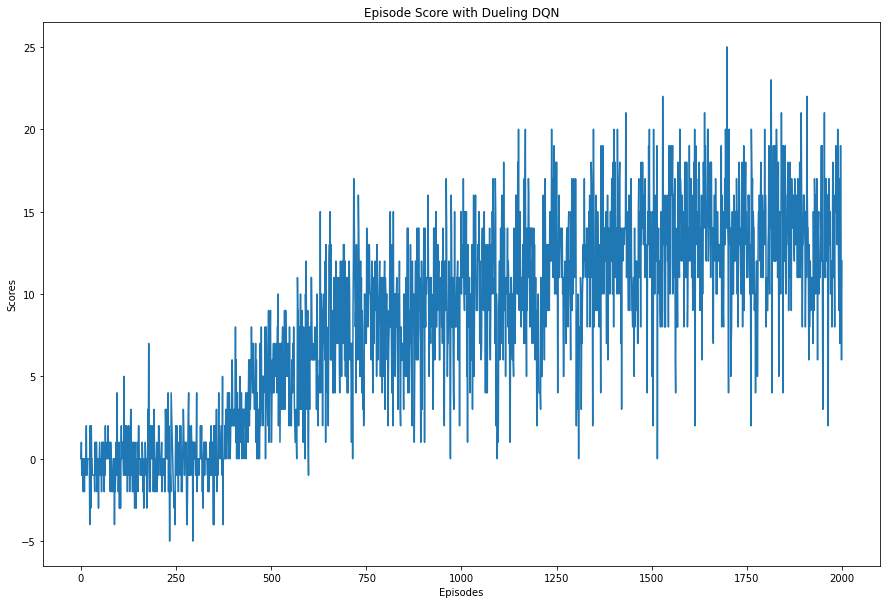

In [6]:
current_time = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
plt.figure(figsize=(15, 10))
plt.plot(episode_score_hist)
plt.title('Episode Score with %s' % algorithm)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.savefig('plot/episode_score_%s_%s.png' % (algorithm, current_time), bbox_inches='tight')

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = agent.preprocessing(env_info.vector_observations[0])            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.action(state, epsilon=epsilon, beta=0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = agent.preprocessing(env_info.vector_observations[0])   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

logger.info("Score: {}".format(score))

2021-02-25 18:51:06,920 INFO Score: 21.0


In [8]:
# save the model and results
checkpoint = {
    'constants': C,
    'step': step,
    'episode_score_hist': episode_score_hist,
    'total_score': total_score,
    'epsilon': epsilon,
    'network_state_dict': agent.network.state_dict(),
    'target_network_state_dict': agent.target_network.state_dict()
}
torch.save(checkpoint, 'save/%s_%s.model' % (algorithm, current_time))
with open('save/agent_memory_%s_%s.data' % (algorithm, current_time), 'wb') as output:
    dill.dump(agent.replay_memory, output)

# Load model weights from the checkpoint

In [ ]:
if algorithm == 'DQN':
    from constants import CONSTANTS as C
    agent_demo = DQNAgent(state_size, action_size, use_cnn_network=True)
elif algorithm == 'Double_DQN':
    from constants import CONSTANTS as C
    agent_demo = DoubleDQNAgent(state_size, action_size, use_cnn_network=True)
elif algorithm == 'Prioritized_Experience_Replay':
    from constants import PRIORITIZED_REPLAY_CONSTANTS as C
    agent_demo = PrioritizedReplayDQNAgent(state_size, action_size, use_cnn_network=True)
    beta = C['beta_begin']
    logger.info('It takes %f steps for beta to go from %f to %f' % ((C['beta_stable']-C['beta_begin'])/C['beta_increase'], C['beta_begin'], C['beta_stable']))
elif algorithm == 'Dueling_DQN':
    from constants import CONSTANTS as C
    agent_demo = DuelingDQNAgent(state_size, action_size, use_cnn_network=True)
else:
    logger.warning('No algorithm specified')

checkpoint = torch.load('save/Double_DQN_20210224_114421.model')
agent_demo.network.load_state_dict(checkpoint['network_state_dict'])
agent_demo.target_network.load_state_dict(checkpoint['target_network_state_dict'])
episode_score_hist = checkpoint['episode_score_hist']
del checkpoint

In [ ]:
current_time = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
plt.figure(figsize=(15, 10))
plt.plot(episode_score_hist)
plt.title('Episode Score with %s' % algorithm)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.savefig('plot/episode_score_%s_%s.png' % (algorithm, current_time), bbox_inches='tight')

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = agent_demo.preprocessing(env_info.vector_observations[0])            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent_demo.action(state, epsilon=epsilon, beta=0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = agent_demo.preprocessing(env_info.vector_observations[0])   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

logger.info("Score: {}".format(score))

In [ ]:
# env.close()